# FL Differential Election Analysis
Beckett76

The following represents an analysis of FL county voting patterns between 2000 and 2020. The results are included in the report "Analysis of Voting Anomalies in Several States" located at https://github.com/beckett76/election_analysis.

The primary data plotted in this analysis are differences of percentage point scores in each county for the Republican presidential candidate between two elections. For example, if Bush won a county with 60% of the vote in 2000 and 66% of the vote in 2004, this would show up as a +6% on the plot.

The consistent structure of the anomalies has lead the author to hypothesize a vote changing scheme which follows the equation:
$$
\Delta{R_i} =  \begin{cases} 
      k \log_{10} (\frac{T_i}{T_0})& T_i \geq T_0 \\
      0 & T_i \le T_0
   \end{cases}
$$
where $\Delta R_i$ are the number of changed R votes in the county and $T_i$ are the total votes in the county. The onset (intercept) parameter $T_0$ indicates the critical county size at which the algorithm begins, and $k$ is the slope of the algorithm (against log of county size).

In the report, the author has developed a parameter fitting method which involves reading the slope $k$ off a log-log plot. The data plotted are the natural log of the ratio of R percentage points between two elections vs the log base 10 of the total votes in a given county. These plots are denoted as the "log ratio" plot. See the report for more details.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Load the data.

FL has some of the best organized data in consistent format among all those studied here. Good job FL!

In [2]:
state = 'FL'

yrs = np.arange(2000,2024,4)
data = {}
for yr in yrs:
    file = f".\{state}_{yr:d}.txt"
    df = pd.read_table(file,delimiter='\t',encoding='cp1252')
    dfp = df.query('RaceCode=="PRE"')

    tot = dfp.groupby('CountyName')['CanVotes'].sum()
    
    dfc = pd.DataFrame()
    dfc['County'] = tot.keys()
    dfc['Total'] = tot.values
    dfc['R'] = dfp.query('PartyCode=="REP"').sort_values('CountyName')['CanVotes'].values
    dfc['D'] = dfp.query('PartyCode=="DEM"').sort_values('CountyName')['CanVotes'].values
    
    data[yr] = dfc
        
    # calculate percentages of vote
    data[yr]['Rp'] = data[yr]['R']/data[yr]['Total']
    data[yr]['Dp'] = data[yr]['D']/data[yr]['Total']

We will define a county as "blue" or "red" based on how they voted in '08 (approximately the midpoint of the analysis). Red represents >=50% Republican presidential vote and blue otherwise.

In [3]:
sR = data[2008]['Rp'] > 0.5 # Red county label
sB = ~sR # Blue county label

Now we will define the plot types to be used

In [4]:
# difference plot
def plot_diff(yr1,yr2,L=0.2,xL=None):
    """
    Plot the difference of election percentage points by county between two years.
    
    yr1 is the first year (key in data)
    yr2 is the second year (key in data)
    L is optional Y axis limit (symmetric)
    """
    tot = data[yr2]['Total']
    plt.semilogx(tot[sR], data[yr2]['Rp'][sR]-data[yr1]['Rp'][sR], 'r.')
    plt.semilogx(tot[sB], data[yr2]['Rp'][sB]-data[yr1]['Rp'][sB], 'b.')
    plt.grid()
    plt.ylim([-L,L])
    if xL is not None:
        plt.xlim(xL)
    plt.xlabel(f'Total Votes - {yr2}')
    plt.ylabel(f'% R {yr2} - % R {yr1}')
    plt.title(f'Difference in R Support in {state} Counties: {yr1} - {yr2}')
    plt.show()
    
def plot_log_ratio(yr1,yr2,L=0.4):
    """
    Plot the log ratio metric (for determining algorithm parameters) between two years.
    
    yr1 is the first year (key in data)
    yr2 is the second year (key in data)
    L is optional Y axis limit (symmetric)
    """
    tot = data[yr2]['Total']
    plt.semilogx(tot[sR], np.log(data[yr2]['Rp'][sR]/data[yr1]['Rp'][sR]), 'r.')
    plt.semilogx(tot[sB], np.log(data[yr2]['Rp'][sB]/data[yr1]['Rp'][sB]), 'b.')
    plt.grid(which="both", ls="-") # nice fine grid lines
    plt.xlabel(f'Total Votes - {yr2}')
    plt.ylabel(f'Ln PP Ratio {yr2}/{yr1}')
    plt.title(f'Log Ratio in R Support in {state} Counties: {yr1} - {yr2}')
    plt.show()

Now we define the function to back out the (conjectured) vote changes.

In [5]:
def adjust_yr(d,k,T0=1e4):
    """
    Adjust data set d to remove the effects of algorithm with parameters `k` and `T_0`.
    Return the total number of changed votes.
    (This function will operate on the data in-place.)
    """
    Lt = np.log10(d['Total'])
    Lt0 = np.log10(T0)
    rho = (Lt - Lt0) * ((Lt - Lt0) > 0) * k # this is the predicted vote change fraction by county
    dR = rho/(1-rho) * d['R'] # predicted total votes changed
    # make the adjustement and recalculate the % vote
    d['R'] += dR
    d['D'] -= dR
    d['Rp'] = d['R']/d['Total']
    d['Dp'] = d['D']/d['Total']
    return dR.sum() # return total votes changed across all counties

## Difference Plots
2000-2004 is nominal

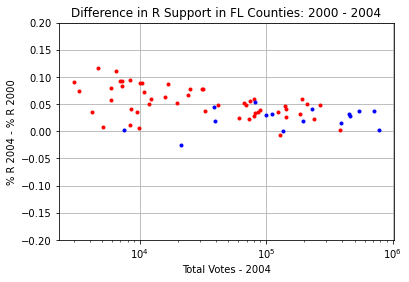

In [6]:
plot_diff(2000,2004)

In FL, the anomalies start here.

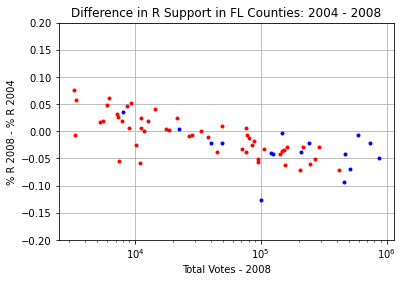

In [7]:
plot_diff(2004,2008)

This is weird. It turns out there are TWO slopes to the anomaly, one from 10k to 100k and another from 100k to 1M.

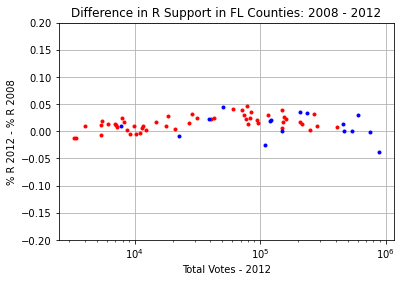

In [8]:
plot_diff(2008,2012)

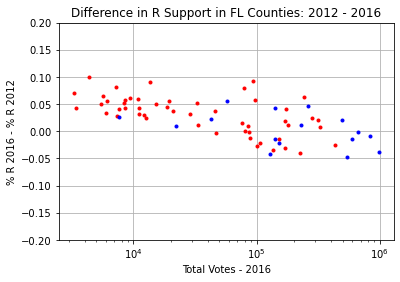

In [9]:
plot_diff(2012,2016)

Two slopes also here. (We will see that the second slope is actually in the 2016 data. We need the log ratio test to bring this into focus.)

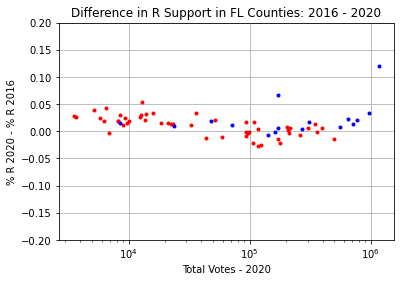

In [10]:
plot_diff(2016, 2020)

"Sanity check" plot, 2004-2020 (axes limits doubled).

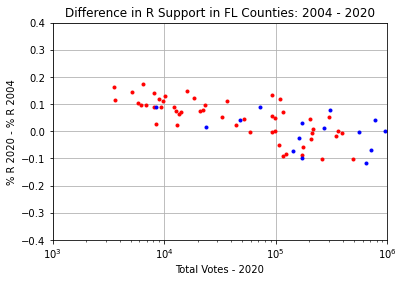

In [11]:
plot_diff(2004,2020,0.4,[1e3,1e6])

## Analysis of Algorithm Parameters

In [12]:
# a place to store our results
# kp and T0p are the "second correction" (if needed)
# this correction is applied after the first correction
dfs = pd.DataFrame(
    index=[2008, 2012, 2016, 2020], 
    columns=['k','T0','kp','T0p','dR','marginR', 'Rp', 'Rp_adj']) # summary data frame

Fit 2008 (if right, second plot should look straight)

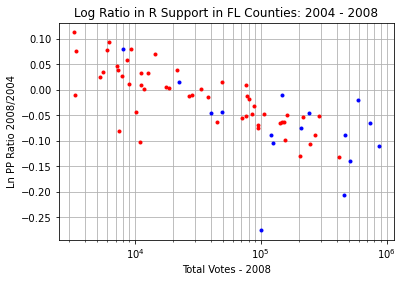

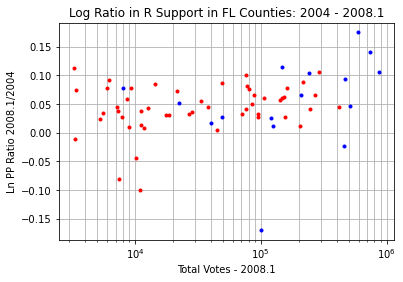

In [13]:
yr = 2008.1; yr0 = 2008
k = 0.1
T0 = 1e4

data[yr] = data[yr0].copy()
dR = adjust_yr(data[yr],k,T0)
plot_log_ratio(yr0-4,yr0)
plot_log_ratio(yr0-4,yr)

dfs.loc[2008]['k'] = k
dfs.loc[2008]['T0'] = T0
# there is no second correction in this data
dfs.loc[2008]['kp'] = 0
dfs.loc[2008]['T0p'] = 0
dfs.loc[2008]['dR'] = dR

# calculate the original margin and adjusted %
dfs.loc[yr0]['marginR'] = data[yr0]['R'].sum() - data[yr0]['D'].sum()
dfs.loc[yr0]['Rp'] = data[yr0]['R'].sum()/data[yr0]['Total'].sum()
dfs.loc[yr0]['Rp_adj'] = (data[yr0]['R'].sum() + dR)/data[yr0]['Total'].sum()

Fix 2012. From the log-ratio test, it is evident that there are different behaviors from 10k to 100k and 100k to 1M.

First fix 10k to 100k. This will be data set 2012.1. Then fix 100k to 1M to yield 2012.2.

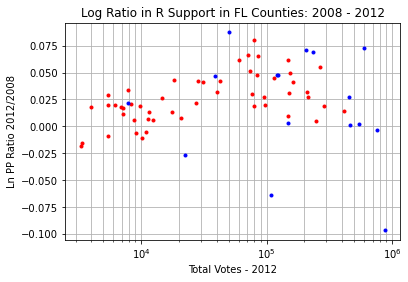

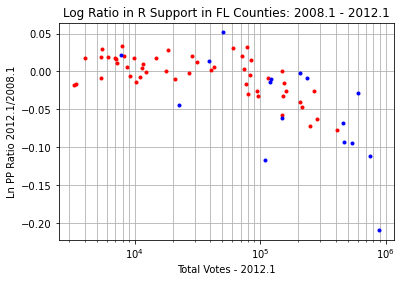

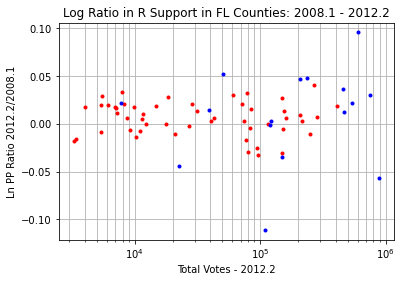

In [14]:
yr = 2012.1; yr0 = 2012
k = 0.05
T0 = 1e4

data[yr] = data[yr0].copy()
dR = adjust_yr(data[yr],k,T0)
plot_log_ratio(yr0-4,yr0)
plot_log_ratio(yr-4,yr)

dfs.loc[yr0]['k'] = k
dfs.loc[yr0]['T0'] = T0

kp = 0.15; T0p = 1e5
data[2012.2] = data[2012.1].copy()
# add these changed votes to the previous
dR += adjust_yr(data[2012.2],kp,T0p)
plot_log_ratio(2008.1,2012.2)

dfs.loc[yr0]['kp'] = kp
dfs.loc[yr0]['T0p'] = T0p
dfs.loc[yr0]['dR'] = dR

# calculate the original margin and adjusted %
dfs.loc[yr0]['marginR'] = data[yr0]['R'].sum() - data[yr0]['D'].sum()
dfs.loc[yr0]['Rp'] = data[yr0]['R'].sum()/data[yr0]['Total'].sum()
dfs.loc[yr0]['Rp_adj'] = (data[yr0]['R'].sum() + dR)/data[yr0]['Total'].sum()

For 2016, there are again 2 slopes. Specifically, the second hides a prominant cluster in large counties.

Note: the second slope is difficult to tell. We can use a "backward recursion" strategy to estimate k=0.08, since then the 2020 data appears to have a single-slope anomaly. (The log plot appears to support at least this slope, so this is conservative.)

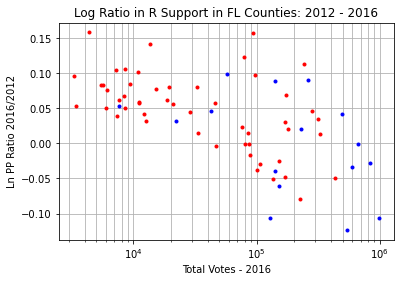

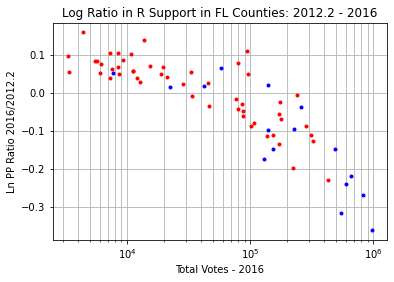

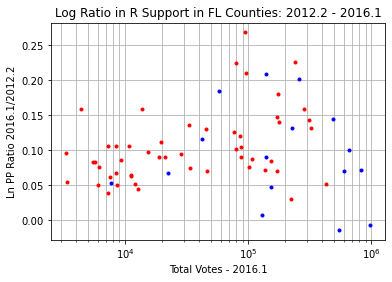

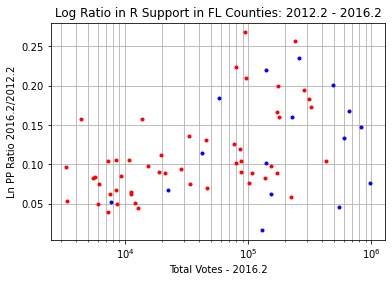

In [15]:
yr = 2016.1; yr0 = 2016
k = 0.15
T0 = 1e4

data[yr] = data[yr0].copy()
dR = adjust_yr(data[yr],k,T0)
plot_log_ratio(yr0-4,yr0)
plot_log_ratio(2012.2,yr0)
plot_log_ratio(2012.2,yr)

dfs.loc[yr0]['k'] = k
dfs.loc[yr0]['T0'] = T0

kp = 0.08; T0p = 1e5
data[2016.2] = data[2016.1].copy()
# add these changed votes to the previous
dR += adjust_yr(data[2016.2],kp,T0p)
plot_log_ratio(2012.2,2016.2)

dfs.loc[yr0]['kp'] = kp
dfs.loc[yr0]['T0p'] = T0p
dfs.loc[yr0]['dR'] = dR

# calculate the original margin and adjusted %
dfs.loc[yr0]['marginR'] = data[yr0]['R'].sum() - data[yr0]['D'].sum()
dfs.loc[yr0]['Rp'] = data[yr0]['R'].sum()/data[yr0]['Total'].sum()
dfs.loc[yr0]['Rp_adj'] = (data[yr0]['R'].sum() + dR)/data[yr0]['Total'].sum()

Fix 2020. Here a single slope will do the job.

The outliers are quite strange. The largest counties do not appear to be "in family" with the rest. This suggests they do not follow the same model in a previous year's corrections.

Honestly, the exponential nature of the log ratio in the original (unmodified) data log ratio is very fishy!

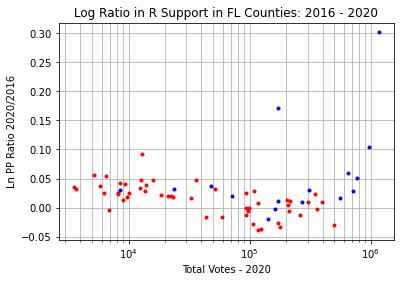

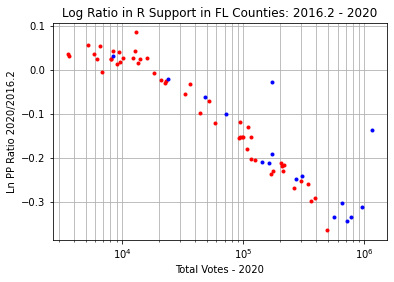

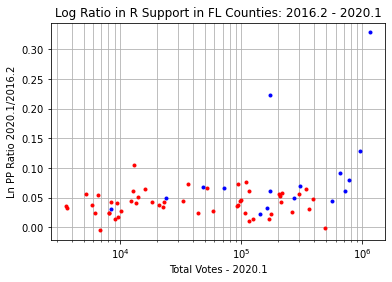

In [16]:
yr = 2020.1; yr0 = 2020
k = 0.18 # this is conservative, it could be 0.25 even
T0 = 1e4

data[yr] = data[yr0].copy()
dR = adjust_yr(data[yr],k,T0)
plot_log_ratio(yr0-4,yr0)
plot_log_ratio(2016.2,yr0)
plot_log_ratio(2016.2,yr)

dfs.loc[yr0]['k'] = k
dfs.loc[yr0]['T0'] = T0
dfs.loc[yr0]['dR'] = dR
dfs.loc[yr0]['kp'] = 0
dfs.loc[yr0]['T0p'] = 0

# calculate the original margin and adjusted %
dfs.loc[yr0]['marginR'] = data[yr0]['R'].sum() - data[yr0]['D'].sum()
dfs.loc[yr0]['Rp'] = data[yr0]['R'].sum()/data[yr0]['Total'].sum()
dfs.loc[yr0]['Rp_adj'] = (data[yr0]['R'].sum() + dR)/data[yr0]['Total'].sum()

# Plot Adjusted Patterns
These look much better!

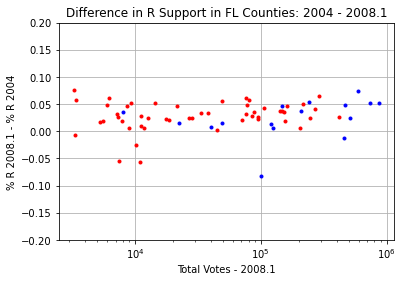

In [17]:
plot_diff(2004, 2008.1)

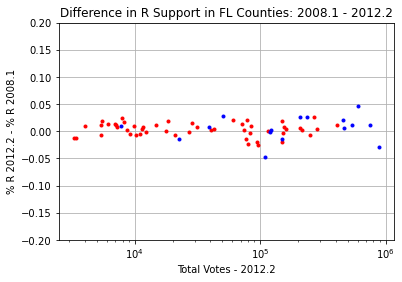

In [18]:
plot_diff(2008.1, 2012.2)

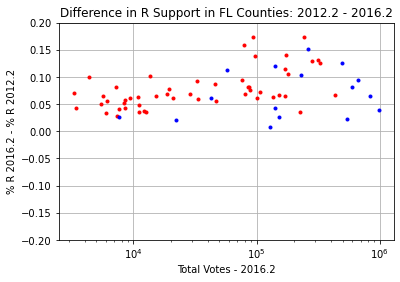

In [19]:
plot_diff(2012.2, 2016.2)

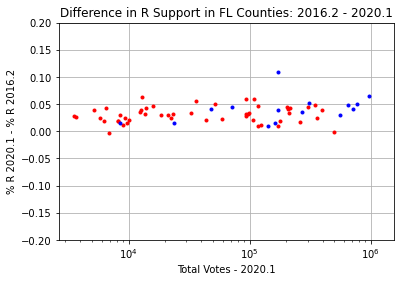

In [20]:
plot_diff(2016.2, 2020.1)

Sanity check for the final result against 2004. Here the large counties appear in family with the rest. This supports the theory that the 2016 data is not in family for these counties.

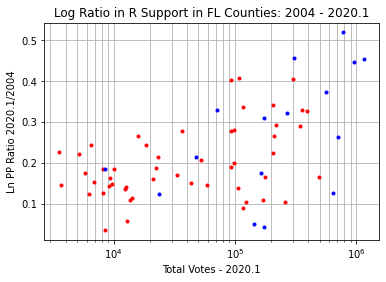

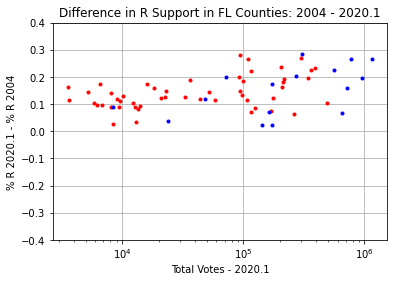

In [21]:
plot_log_ratio(2004,2020.1)
plot_diff(2004, 2020.1, 0.4) # had to adjust the plot axes here...

## Summary Results
Here are the summarized parameters and total votes changed by year. Recall kp and T0p are the "second correction" (if applicable).

2.1M votes will tend to ruin your day...

In [23]:
dfs

,k,T0,kp,T0p,dR,marginR,Rp,Rp_adj
2008,0.1,10000,0,0,648237,-236450,0.482153,0.559409
2012,0.05,10000,0.15,100000,624983,-74309,0.49131,0.565061
2016,0.15,10000,0.08,100000,1.49221e+06,112911,0.490219,0.648628
2020,0.18,10000,0,0,2.14647e+06,371686,0.512198,0.706143


Here is the list of FL counties that showed a large increase for Trump in 2016 (in the adjusted data). All of these counties except one are in central FL, and they span almost all of central FL except for Orlando.

In [24]:
data[2016][data[2016.2]['Rp'] - data[2012.2]['Rp'] > 0.08].sort_values('Total', ascending=False)

,County,Total,R,D,Rp,Dp
49,Palm Beach,662332,272402,374673,0.411277,0.565688
27,Hillsborough,597660,266870,307896,0.446525,0.515169
51,Pinellas,492403,239201,233701,0.485783,0.474613
34,Lee,326420,191551,124908,0.586824,0.382660
4,Brevard,314752,181848,119679,0.577750,0.380233
52,Polk,284314,157430,117433,0.553719,0.413040
63,Volusia,260869,143007,109091,0.548195,0.418183
50,Pasco,241139,142101,90142,0.589291,0.373818
55,Sarasota,229063,124438,97870,0.543248,0.427262
39,Manatee,178958,101944,71224,0.569653,0.397993


This image shows the location of the counties on the list with 8pp increase in support (pink) or >=10pp increase in support (red)
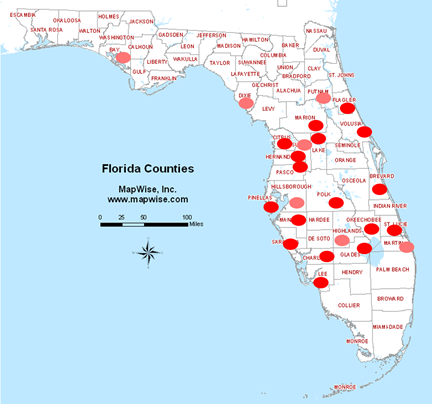

Here are the counties with extreme outliers for increase in Trump support in 2020.
Hendry County - 40% Hispanic
Osceola County - 48% Hispanic
Broward County - 13% Hispanic, 30% Black
Miami-Dade - 70% Hispanic

In [25]:
data[2020.1][np.log(data[2020.1]['Rp']/data[2016.2]['Rp']) > 0.1].sort_values('Total', ascending=False)

,County,Total,R,D,Rp,Dp
42,Miami-Dade,1156816,847633.575061,303063.424939,0.732730,0.261981
5,Broward,957672,518213.953309,433947.046691,0.541118,0.453127
48,Osceola,172436,94519.347985,76257.652015,0.548142,0.442237
24,Hendry,12940,8068.566855,4766.433145,0.623537,0.368349


## Benford's Law Excursion
In this analysis, we see if the changes have any effects on Benford's law.

In [26]:
# compute leading digit in base b
def leading(d,b=10):
    return d//b**(np.floor(np.log(d)/np.log(b)))

# plot against Benford's law (in base b)
def plot_benford(lead,label,b=10):    
    count,bins = np.histogram(lead,range(1,b+1))
    d = np.arange(1,b)
    plt.plot(d, count/len(lead),'-x');
    # Benford's law
    plt.plot(d, (np.log(d+1) - np.log(d))/np.log(b))
    plt.legend([label, "Benford's Law"])
    plt.title(f"Benford's Law Analysis in Base {b}: {label}")
    plt.grid(); 
    plt.show()

First, check how well total votes matches Benford. (4 and 9 are strange, especially 9). Some weirdness is to be expected due to sample size.

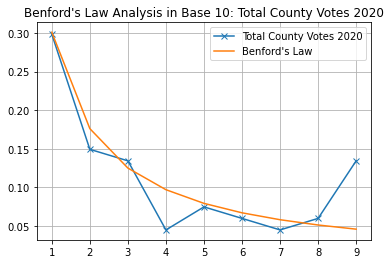

In [27]:
base = 10
yr = 2020
plot_benford(leading(data[yr]['Total'],base), f'Total County Votes {yr}', base)


See how well original R votes and modified R votes match for 2020. There is not a conclusive difference. (Actually, the adjusted version looks better!)

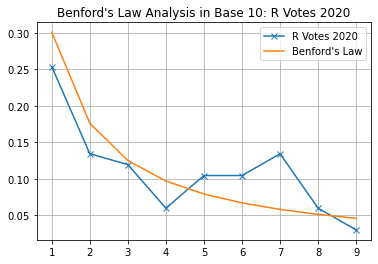

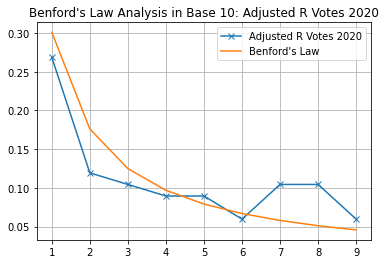

In [28]:
plot_benford(leading(data[yr]['R'],base), f'R Votes {yr}', base)
plot_benford(leading(data[yr+0.1]['R'],base), f'Adjusted R Votes {yr}', base)

Same analysis for the D votes.

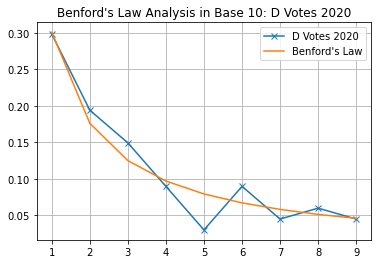

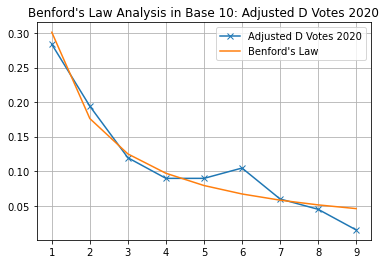

In [29]:
plot_benford(leading(data[yr]['D'],base), f'D Votes {yr}', base)
plot_benford(leading(data[yr+0.1]['D'],base), f'Adjusted D Votes {yr}', base)

See how bad it looks if we just contrive some fixed vote addition to every county. (Looks fishy)

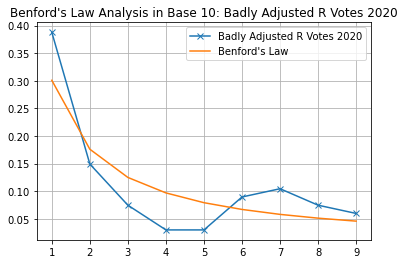

In [30]:
plot_benford(leading(data[yr]['R']+4000,base), f'Badly Adjusted R Votes {yr}', base)

## Conclusion
Read the report!

Feel free to modify the code to do additional analyses (and additional states).

Be safe and good luck out there.

# God Bless America